Cook County Illinois, which includes the city of Chicago, collects property tax. It does not collect income tax. Would it be more fair to switch to income tax?

I compare the property tax paid per homeowner in Cook County Illinois to the median income of census tracts.

Linear regression shows that the effective tax rate is practically independent of income.  However this result ignores that these is very large variance at low income and very small variance at high income. This means that although the average tax rate for low and high incomes are practically the same, a low income person is much more likely to be overtaxed than a high income person.  

I demonstrare this quantitatively by calculating the median income of people who are taxed above certain rates. 

Import stuff I need and lots of stuff I don't

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.decomposition import PCA
#from library.sb_utils import save_file
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import pickle
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime


Upload into memory the data file acquired from the Cook County Assessor's gitlab. It is in parquet format.

In [2]:
table = pq.read_table('../data/raw/assmntdata.parquet')

Convert to pandas dataframes.

In [3]:
df = table.to_pandas()


examine columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098894 entries, 0 to 1098893
Data columns (total 95 columns):
 #   Column                        Non-Null Count    Dtype   
---  ------                        --------------    -----   
 0   meta_pin                      1098894 non-null  object  
 1   meta_year                     1098894 non-null  float64 
 2   meta_class                    1098894 non-null  object  
 3   meta_town_code                1098894 non-null  object  
 4   meta_nbhd                     1098894 non-null  object  
 5   meta_2yr_pri_board_est_bldg   1097104 non-null  float64 
 6   meta_2yr_pri_board_est_land   1097104 non-null  float64 
 7   meta_1yr_pri_board_est_bldg   1098894 non-null  float64 
 8   meta_1yr_pri_board_est_land   1098894 non-null  float64 
 9   meta_mailed_est_bldg          1098894 non-null  float64 
 10  meta_mailed_est_land          1098894 non-null  float64 
 11  meta_certified_est_bldg       1098894 non-null  float64 
 12  meta_certified

In [5]:
df.head()

,meta_pin,meta_year,meta_class,meta_town_code,meta_nbhd,meta_2yr_pri_board_est_bldg,meta_2yr_pri_board_est_land,meta_1yr_pri_board_est_bldg,meta_1yr_pri_board_est_land,meta_mailed_est_bldg,...,time_sale_month_of_year,time_sale_week_of_year,time_sale_day_of_year,time_sale_during_school_year,time_sale_during_holidays,ind_multi_code,ind_large_home,ind_class_error,ind_garage,ind_complete_predictors
0,01011000040000,2020.0,212,10,10012,374930.0,52510.0,320210.0,58030.0,320210.0,...,Jan,1.0,1.0,True,True,False,False,False,True,True
1,01011000050000,2020.0,205,10,10012,216890.0,31030.0,275500.0,34300.0,275500.0,...,Jan,1.0,1.0,True,True,False,False,False,True,True
2,01011000060000,2020.0,212,10,10012,353260.0,31030.0,296390.0,34300.0,296390.0,...,Jan,1.0,1.0,True,True,False,False,False,True,True
3,01011000090000,2020.0,212,10,10012,668790.0,64460.0,604870.0,71240.0,604870.0,...,Jan,1.0,1.0,True,True,False,False,False,True,True
4,01011000170000,2020.0,205,10,10012,291310.0,42870.0,355640.0,47390.0,355640.0,...,Jan,1.0,1.0,True,True,False,False,False,False,True


The columns I want are econ_tax_amt_paid, and econ_midincome.

In [6]:
columns =['econ_tax_amt_paid','econ_midincome']

In [7]:
df[columns].head()

,econ_tax_amt_paid,econ_midincome
0,4224.475455,148670.0
1,4224.475455,148670.0
2,4224.475455,148670.0
3,5542.137143,148670.0
4,4569.021964,148670.0


In [8]:
df_econ = df[columns]

We are interested in the effective income tax rate = (property tax)/income

In [9]:
df_econ['rate'] = df_econ['econ_tax_amt_paid']/df_econ['econ_midincome']

/var/folders/qc/g6yf7hvd019dnqj11v94qpbw0000gn/T/ipykernel_21665/3638010147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_econ['rate'] = df_econ['econ_tax_amt_paid']/df_econ['econ_midincome']


In [10]:
df_econ.head()

,econ_tax_amt_paid,econ_midincome,rate
0,4224.475455,148670.0,0.028415
1,4224.475455,148670.0,0.028415
2,4224.475455,148670.0,0.028415
3,5542.137143,148670.0,0.037278
4,4569.021964,148670.0,0.030733


<AxesSubplot:xlabel='econ_midincome', ylabel='rate'>

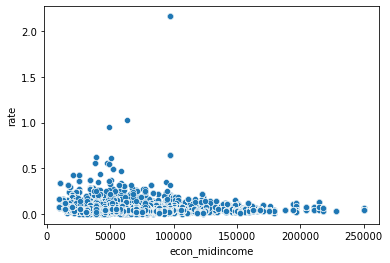

In [11]:
sns.scatterplot(data = df_econ,x='econ_midincome',y='rate')

There is a very slight tendency in favor of high income. This can be seen by linear regression.

In [12]:
ln = LinearRegression()
ln.fit(df_econ[['econ_midincome']],df_econ.rate)
ln.coef_

array([-1.7594881e-08])

This is effectively flat. A change in income by 1 million dollars decreases the effective tax rate by only 1.76%. However, the coefficient isn't the most important thing but the variation. From the graph it can be seen that there is much greater variation of tax rate for low income census tracks. To see this we calculate the median rate and median income.

In [13]:
median_rate = df_econ.rate.median()
median_rate

0.043315651405796754

In [14]:
median_income = df_econ.econ_midincome.median()
median_income, df_econ.shape[0]

(64659.0, 1098894)

Now look at median income for those charged more than the median rate.

In [15]:
df_overtaxed = df_econ[df_econ.rate>1*median_rate]
median_income_overtaxed = df_overtaxed.econ_midincome.median()
median_income_overtaxed, df_overtaxed.shape[0]

(63301.0, 548800)

The median income of the overtaxed group is about the same as the over all median income. But now look at the median income of the group that is taxes at twice the median rate or higher.

In [16]:
df_overtaxed = df_econ[df_econ.rate>2*median_rate]
median_income_overtaxed = df_overtaxed.econ_midincome.median()
median_income_overtaxed, df_overtaxed.shape[0]

(53549.0, 52385)

We see that the median has gone down by almost $10,000. Let's see how the trend continues...

In [17]:
median_income=np.empty(7)
total =np.empty(7)
for n in range(0,7):
    median_income[n] = df_econ[df_econ.rate>n*median_rate].econ_midincome.median()
    total[n] = df_econ[df_econ.rate>n*median_rate].shape[0]

    


In [18]:
median_income

array([64659., 63301., 53549., 38427., 36927., 36927., 36406.])

In [19]:
total

array([1.098789e+06, 5.488000e+05, 5.238500e+04, 1.454000e+04,
       3.635000e+03, 1.957000e+03, 7.940000e+02])

In [20]:
100*total/total[0]

array([1.00000000e+02, 4.99458950e+01, 4.76752133e+00, 1.32327499e+00,
       3.30818747e-01, 1.78105169e-01, 7.22613714e-02])

<AxesSubplot:>

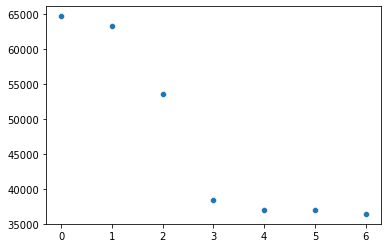

In [21]:
sns.scatterplot(x=range(0,7), y= median_income)

The median income continues to fall as we consider groups of people taxed at higher and higher effective rates. The graph below shows the fraction of people effected is also getting smaller.

<AxesSubplot:>

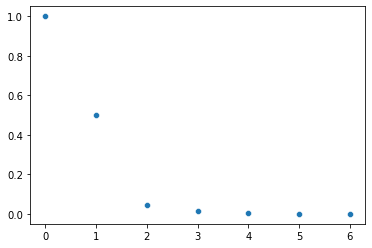

In [22]:
sns.scatterplot(x=range(0,7), y= total/total[0])

Conclusion: Linear regression showed that there was little bias in the average tax rate. But greater variance at low income means that a low income person is more likely to be overtaxed than a high income person. 